<h1>Part 1: Importing Libraries</h1>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import imblearn

<h1>Part 2: Data Exploration</h1>

In [2]:
trainDataMulti = pd.read_csv('data\TrainingDataMulti.csv', sep=',')
testDataMulti = pd.read_csv('data\TestingDataMulti.csv', sep=',')

# to check whether data was correctly loaded
print("Part B Training Data")
trainDataMulti.info() 
print("\nPart B Testing Data")
testDataMulti.info()

Part B Training Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Columns: 129 entries, R1-PA1:VH to marker
dtypes: float64(112), int64(17)
memory usage: 5.9 MB

Part B Testing Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 128 entries, R1-PA1:VH to snort_log4
dtypes: float64(104), int64(24)
memory usage: 100.1 KB


Detecting invalid data and missing values within the dataset.

In [3]:
na_detected = False
NaN_detected = False

for i in range(128):
    na_count = trainDataMulti.isna().values.any()
    NaN_count = trainDataMulti.isnull().values.any()
    if NaN_count != 0:
        #print('Column' + i + 'has' + NaN_count + 'NaN values.\n')
        NaN_detected = True
    if na_count != 0:
        na_detected = True

if NaN_detected == False:
    print('No NaN values were detected.')
    
if na_detected == False:
    print('No N/A values were detected')

No NaN values were detected.
No N/A values were detected


Verifying event label distribution

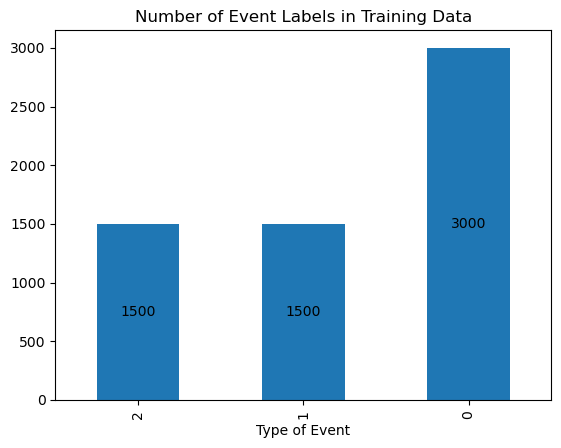

In [4]:
labelplt = trainDataMulti['marker'].value_counts().sort_values().plot(kind='bar', title='Number of Event Labels in Training Data', xlabel='Type of Event')
labelplt.bar_label(labelplt.containers[0], label_type = 'center')
plt.show()

<h1>Part 3: Data Preprocessing</h1>

In [5]:
from sklearn.model_selection import train_test_split

# getting the labels
Y = trainDataMulti['marker']
# removing the labels in the dataset
X = trainDataMulti.drop('marker',axis=1)

In [6]:
from imblearn.over_sampling import SMOTE

sampler = SMOTE(random_state=58)
X, Y = sampler.fit_resample(X, Y)

In [7]:
# ensuring resampled dataset using SMOTE has balanced label distribution
Y.value_counts()

0    3000
2    3000
1    3000
Name: marker, dtype: int64

In [8]:
# splitting the training dataset into training set and test set
# 80-20 split (larger training set to improve model performance)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=58, stratify=Y)

In [9]:
# ensuring test set has balanced split of labels
Y_test.value_counts()

1    600
0    600
2    600
Name: marker, dtype: int64

Standardizing all features using StandardScaler

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
testDataMulti = scaler.transform(testDataMulti)

<h1>Part 4: Feature Selection</h1>

None. Raw features were used to train the model.

<h1>Part 5: Model Selection</h1>

In [11]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=8, min_samples_split = 5, n_jobs=-1, random_state=58)

<h1>Part 6: Hyperparameter Tuning</h1>

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "min_samples_split": [2, 3, 4, 5, 6],
    "max_depth": [6, 7, 8, 9, 10],
}

bestclf = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, verbose=4)
bestclf.fit(X_train, Y_train)
print("Best parameter (CV score=%0.3f):" % bestclf.best_score_)
print(bestclf.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameter (CV score=0.913):
{'max_depth': 10, 'min_samples_split': 3}


In [13]:
results = pd.DataFrame(bestclf.cv_results_)
print(results)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        2.405690      2.167024         4.665624        3.738805   
1        8.128058      1.374803         5.555260        0.819742   
2        5.516866      2.252803         5.532995        0.705523   
3       10.064894      2.700587         9.071613        2.947191   
4       11.341731      2.068991        10.405923        2.778626   
5       15.557156      4.132125         8.424606        1.241353   
6       19.629242      2.368595         7.399294        1.999133   
7       17.328282      2.101263         8.544009        1.386081   
8       14.526347      2.469571         9.611180        1.638890   
9       15.454391      1.760632        10.609114        3.313246   
10      18.040559      4.933905        10.951586        1.240587   
11      17.353580      1.578911         8.346872        1.888310   
12      18.453098      3.769750         8.672022        3.141112   
13      17.624199      2.180250         7.327089

<h1>Part 7: Final Evaluation on Test Set</h1>

                   precision    recall  f1-score   support

           normal       0.90      0.95      0.92       600
   data_injection       0.94      0.89      0.91       600
command_injection       0.90      0.90      0.90       600

         accuracy                           0.91      1800
        macro avg       0.91      0.91      0.91      1800
     weighted avg       0.91      0.91      0.91      1800

Final Accuracy:  0.9122222222222223


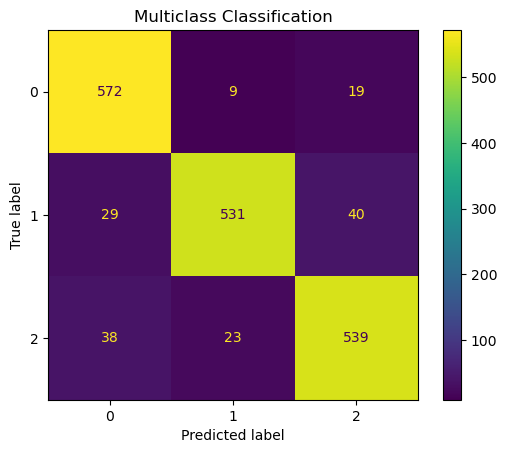

In [14]:
from sklearn import metrics
Y_pred = bestclf.predict(X_test)
target_names = ['normal', 'data_injection', 'command_injection']
print(metrics.classification_report(Y_test, Y_pred, target_names=target_names))

accuracy = bestclf.score(X_test, Y_test)
print("Final Accuracy: ", accuracy)

cm = metrics.confusion_matrix(Y_test, Y_pred)
cmplt = metrics.ConfusionMatrixDisplay(cm, display_labels={"2","1","0"})
cmplt.plot()

plt.title("Multiclass Classification")
plt.show()

<h1>Part 8: Predicting Test Set</h1>

In [15]:
Y_final = bestclf.predict(testDataMulti)
Y_final = pd.DataFrame(Y_final, columns=['Final Prediction'])

In [16]:
Y_final.value_counts()

Final Prediction
1                   35
0                   33
2                   32
dtype: int64

<h1>Part 9: Exporting to .csv File</h1>

In [17]:
Y_final.to_csv('results_csv/B-Final.csv', index=False)